In [1]:
import numpy as np
from sklearn.linear_model import LinearRegression
import seaborn as sns
import matplotlib.pyplot as plt
import scipy
import numpy as np
from scipy.stats import norm
import pandas as pd
import scipy.stats as stats
import time
from tqdm.notebook import tqdm
from sklearn.linear_model import Ridge
import random

## Bandits data generating function

In [2]:
def getContexts(M):
    contexts = np.zeros((M, 2))
    
    for i in range(M):
        
        temp = np.random.normal(0, 1, 2)
        temp = temp / np.linalg.norm(temp)
        
        contexts[i, :] = temp
    
    return contexts

In [3]:
def getRidgeEstimate(xs, ys, lambdaPar):
    
    clf = Ridge(alpha=1.0)
    clf.fit(xs, ys)
    
    return clf.coef_.T


def getBestArm(xs, ys, lambdaPar, contexts):
    
    thetahat = getRidgeEstimate(xs, ys, lambdaPar)
    idx = np.argmax(contexts @ thetahat)
    
    return idx  
    

In [4]:
def getGreedyBandit(n, lambdaPar, contexts, epsVec,  M =50,  thetastar = 0.3 * np.ones((2, 1))):
    
    
    xs = np.zeros((n, 2))
    ys = np.zeros((n, 1))
    
    for i, epsProb in enumerate(epsVec):
        
        if i <= 5:
            idx = random.randint(0, M - 1) 
            xs[i, :] = contexts[idx, :] 
            ys[i, :] = np.dot(xs[i, :], thetastar) + np.random.normal(0, 1, 1)[0]
            
        else:
            b = np.random.binomial(1, epsProb , 1)
            if b == 1:
                idx = random.randint(0, M - 1) 
                xs[i, :] = contexts[idx, :] 

            else:
                bestArm = getBestArm(xs[:(i - 1), :], ys[: (i - 1), :], lambdaPar, contexts)
                xs[i, :] = contexts[bestArm, :]
                
                
        ys[i, :] = np.dot(xs[i, :], thetastar) + np.random.normal(0, 1, 1)[0]

    return xs, ys

In [5]:
def getODEstimate(xs, ys, contexts, epsVec, gamma = 'loglog'):
    
    n, dim = xs.shape
    
    if gamma == 'loglog':
        gamman = 1.0 / (np.log(n) * np.log(np.log(n)))
        
    if gamma == 'logloglog':
        gamman = 1.0 / (np.log(n) * np.log(np.log(np.log(n))))
    
    W = np.zeros((n, dim))
    Delta = np.eye(dim)
    
    numContexts,_ = contexts.shape
    G = (contexts.T @ contexts) / numContexts 
    sumEps = np.sum(epsVec)
    
    for i in range(n):
    
        Gi = sumEps * G  

        # define 
        zi = scipy.linalg.sqrtm(np.linalg.inv(Gi))@xs[i,:].reshape(-1,1)
        wi = Delta@zi.reshape(-1,1)/(gamman/2 + np.sum(zi**2))
        Delta = Delta - wi@zi.reshape(1,-1)
        W[i,:] = wi.reshape(-1)
    
    #computing the OLS
    M = LinearRegression( fit_intercept = False).fit(xs, ys)
    ols = M.coef_.reshape(-1,1)
    S = xs.transpose()@xs
    invS = np.linalg.inv(S)
    res = ys - xs@ols
    
    #diag scaling 
    DnHalf = np.diag([ 1.0 / np.sqrt(invS[0, 0]), 1.0/np.sqrt(invS[1, 1])])
    DnMinusHalf = np.diag([np.sqrt(invS[0, 0]), np.sqrt(invS[1, 1])])
    
    beta = np.linalg.norm(DnHalf @ scipy.linalg.sqrtm(invS), ord = 2)
    
    #computing OD
    OD = ols + beta * DnMinusHalf@(W.transpose()@res)
    
    return OD, ols


In [6]:

def getBanditCI(xs, ys, alpha, OD, coordinate = 0, onesided = 1<0, gamma = 'loglog'):
    
    if gamma == 'loglog':
        gamman = 1.0 / (np.log(n) * np.log(np.log(n)))
        
    if gamma == 'logloglog':
        gamman = 1.0 / (np.log(n) * np.log(np.log(np.log(n))))
    
    S = xs.transpose()@xs 
    sdHat = estimateSd(xs, ys)
    invS = np.linalg.inv(S)
    
    DnHalf = np.diag([ 1.0 / np.sqrt(invS[0, 0]), 1.0/np.sqrt(invS[1, 1])])
    DnMinusHalf = np.diag([np.sqrt(invS[0, 0]), np.sqrt(invS[1, 1])])
    betan = np.linalg.norm(DnHalf @ scipy.linalg.sqrtm(invS), ord = 2)
    
    if coordinate == 0:


        if not onesided:
            LB = OD[0, 0] -  norm.ppf(1 - alpha/2) * np.sqrt(invS[0, 0]) * np.sqrt(1.0 / gamman) * sdHat * betan
            UB = OD[0, 0] +  norm.ppf(1 - alpha/2) * np.sqrt(invS[0, 0]) * np.sqrt(1.0 / gamman) * sdHat * betan

            return LB, UB

        else:
            RightCI = OD[0, 0] -  norm.ppf(1 - alpha) * np.sqrt(invS[0, 0]) * np.sqrt(1.0 / gamman) * sdHat * betan
            LeftCI = OD[0, 0] +  norm.ppf(1 - alpha) * np.sqrt(invS[0, 0]) * np.sqrt(1.0 / gamman)  * sdHat * betan

            return LeftCI, RightCI
        
    else: # coordinate  = 1
        
        if not onesided:
            LB = OD[1, 0] -  norm.ppf(1 - alpha/2) * np.sqrt(invS[1, 1]) * np.sqrt(1.0 / gamman) * sdHat * betan
            UB = OD[1, 0] +  norm.ppf(1 - alpha/2) * np.sqrt(invS[1, 1]) * np.sqrt(1.0 / gamman) * sdHat * betan

            return LB, UB

        else:
            RightCI = OD[1, 0] -  norm.ppf(1 - alpha) * np.sqrt(invS[1, 1]) * np.sqrt(1.0 / gamman) * sdHat * betan
            LeftCI = OD[1, 0] +  norm.ppf(1 - alpha) * np.sqrt(invS[1, 1]) * np.sqrt(1.0 / gamman)  * sdHat * betan

            return LeftCI, RightCI
        
def checkInTwoCI(CILims, par):
        return CILims[0] <= par <= CILims[1]
    
def checkInOneCI(CILims, par, rightCI = 1>0):
    
    if rightCI: # checking if par in right-sided interval 
        return par >= CILims
    
    else: # checking if par in left-sided interval 
        return par <= CILims
    
        


def getBanditCIols(xs, ys, alpha, OLS, coordinate = 0, onesided = 1<0):
    
    
    S = xs.transpose()@xs 
    sdHat = estimateSd(xs, ys)
    invS = np.linalg.inv(S)
    
    if coordinate == 0:


        if not onesided:
            LB = OLS[0, 0] -  norm.ppf(1 - alpha/2) * np.sqrt(invS[0, 0]) * sdHat
            UB = OLS[0, 0] +  norm.ppf(1 - alpha/2) * np.sqrt(invS[0, 0]) * sdHat

            return LB, UB

        else:
            RightCI = OLS[0, 0] -  norm.ppf(1 - alpha) * np.sqrt(invS[0, 0]) * sdHat
            LeftCI = OLS[0, 0] +  norm.ppf(1 - alpha) * np.sqrt(invS[0, 0]) * sdHat

            return LeftCI, RightCI
        
    else: # coordinate  = 1
        
        if not onesided:
            LB = OLS[1, 0] -  norm.ppf(1 - alpha/2) * np.sqrt(invS[1, 1]) * sdHat
            UB = OLS[1, 0] +  norm.ppf(1 - alpha/2) * np.sqrt(invS[1, 1]) * sdHat

            return LB, UB

        else:
            RightCI = OLS[1, 0] -  norm.ppf(1 - alpha) * np.sqrt(invS[1, 1]) * sdHat
            LeftCI = OLS[1, 0] +  norm.ppf(1 - alpha) * np.sqrt(invS[1, 1]) * sdHat

            return LeftCI, RightCI
        

        
def estimateSd(xs,ys):
    
    n, _ = np.shape(xs)
    
    #computing the OLS
    M = LinearRegression( fit_intercept = False).fit(xs, ys)
    ols = M.coef_.reshape(-1,1)
    S = xs.transpose()@xs
    res = ys - xs@ols
    
    varEstimate = np.sum(res**2) / n
    
    return np.sqrt(varEstimate)

def getBanditCIconc(xs, ys, alpha, lambdaPar, subGPar, thetastarNorm, xBound, coordinate = 0, onesided = 1<0):
    
    
    S = xs.transpose()@xs
    Vt = S + lambdaPar * np.eye(2)
    sdHat = estimateSd(xs, ys)
    invVt = np.linalg.inv(Vt)
    OLS_Ridge = getRidgeEstimate(xs, ys, lambdaPar)
    
    factor = subGPar * np.sqrt(2 * np.log( (lambdaPar + n*xBound ) / (lambdaPar *(1-alpha)))) + np.sqrt(lambdaPar) * thetastarNorm
    
    if coordinate == 0:


        if not onesided:
            LBconc = OLS_Ridge[0, 0] -  norm.ppf(1 - alpha/2) * np.sqrt(invVt[0, 0]) * sdHat * factor
            UBconc = OLS_Ridge[0, 0] +  norm.ppf(1 - alpha/2) * np.sqrt(invVt[0, 0]) * sdHat * factor
            
            return LBconc, UBconc

        else:
            RightCIconc = OLS_Ridge[0, 0] -  norm.ppf(1 - alpha) * np.sqrt(invVt[0, 0]) * sdHat * factor
            LeftCIconc = OLS_Ridge[0, 0] +  norm.ppf(1 - alpha) * np.sqrt(invVt[0, 0]) * sdHat * factor

            return LeftCIconc, RightCIconc
        
    else: # coordinate  = 1
        
        if not onesided:
            LBconc = OLS_Ridge[1, 0] -  norm.ppf(1 - alpha/2) * np.sqrt(invVt[1, 1]) * sdHat * factor
            UBconc = OLS_Ridge[1, 0] +  norm.ppf(1 - alpha/2) * np.sqrt(invVt[1, 1]) * sdHat * factor

            return LBconc, UBconc

        else:
            RightCIconc = OLS_Ridge[1, 0] -  norm.ppf(1 - alpha) * np.sqrt(invVt[1, 1]) * sdHat * factor
            LeftCIconc = OLS_Ridge[1, 0] +  norm.ppf(1 - alpha) * np.sqrt(invVt[1, 1]) * sdHat * factor

            return LeftCIconc, RightCIconc
    

## Simulation set up 

In [7]:
n, R = 1000, 1000 # num-repliactions and numobs
M = 50
numalphas = 25
alphas = 1 - np.linspace(0.75, 0.99, numalphas)

countsTwoSided, countsLeftSided, countsRightSided = np.zeros((numalphas, 2)), np.zeros((numalphas, 2)), np.zeros((numalphas, 2))
countsTwoSidedols, countsLeftSidedols, countsRightSidedols = np.zeros((numalphas, 2)), np.zeros((numalphas, 2)), np.zeros((numalphas, 2))
countsTwoSidedconc, countsLeftSidedconc, countsRightSidedconc = np.zeros((numalphas, 2)), np.zeros((numalphas, 2)), np.zeros((numalphas, 2))


countsTwoSided, countsLeftSided, countsRightSided = np.zeros((numalphas, 2)), np.zeros((numalphas, 2)), np.zeros((numalphas, 2))
countsTwoSidedols, countsLeftSidedols, countsRightSidedols = np.zeros((numalphas, 2)), np.zeros((numalphas, 2)), np.zeros((numalphas, 2))
countsTwoSidedconc, countsLeftSidedconc, countsRightSidedconc = np.zeros((numalphas, 2)), np.zeros((numalphas, 2)), np.zeros((numalphas, 2))


CIwidthOLS, CIwidthConc, CIwidthOD = np.zeros((numalphas, 2)), np.zeros((numalphas, 2)), np.zeros((numalphas, 2))



lambdaPar = 0.1
# epsVec = [ np.minimum(1.0 / (i + 1)**0.5, 0.5) for i in range(n)]
epsVec = [ np.minimum(1.0 / (i + 1)**0.5, 0.5) for i in range(n)]
contexts = getContexts(M)

subGPar = 2
thetastarNorm = 2
xBound = 2

seed = 1234
np.random.seed(seed)


for i in tqdm(range(R)):
    for coordinate in [0, 1]:


        xs, ys = getGreedyBandit(n, lambdaPar, contexts, epsVec, M)
        OD, OLS = getODEstimate(xs, ys, contexts, epsVec)

        for a, alpha in enumerate(alphas):

            LB, UB = getBanditCI(xs, ys, alpha, OD, coordinate = coordinate, gamma = 'loglog')
            LeftCILim, RightCILim = getBanditCI(xs, ys, alpha, OD, coordinate = coordinate, onesided=1>0, gamma = 'loglog')
            
            CIwidthOD[a, coordinate] += UB - LB
            countsTwoSided[a, coordinate] += checkInTwoCI([LB, UB], 0.3)
            countsRightSided[a, coordinate] += checkInOneCI(RightCILim, 0.3)
            countsLeftSided[a, coordinate] += checkInOneCI(LeftCILim, 0.3, rightCI=1<0)


            # OLS CIs

            LBols, UBols = getBanditCIols(xs, ys, alpha, OLS, coordinate = coordinate)
            LeftCILimols, RightCILimols = getBanditCIols(xs, ys, alpha, OLS, coordinate = coordinate, onesided=1>0)

            CIwidthOLS[a, coordinate] += UBols - LBols 
            countsTwoSidedols[a, coordinate] += checkInTwoCI([LBols, UBols], 0.3)
            countsRightSidedols[a, coordinate] += checkInOneCI(RightCILimols, 0.3)
            countsLeftSidedols[a, coordinate] += checkInOneCI(LeftCILimols, 0.3, rightCI=1<0)

                
            # conc CIs
            
            LBconc, UBconc = getBanditCIconc(xs, ys, alpha, lambdaPar, subGPar, thetastarNorm, xBound, coordinate = coordinate)
            LeftCILimols, RightCILimols = getBanditCIconc(xs, ys, alpha, lambdaPar, subGPar, thetastarNorm, xBound, coordinate = coordinate, onesided=1>0)
            
            CIwidthConc[a, coordinate] += UBconc - LBconc 
            
            countsTwoSidedconc[a, coordinate] += checkInTwoCI([LBols, UBols], 0.3)
            countsRightSidedconc[a, coordinate] += checkInOneCI(RightCILimols, 0.3)
            countsLeftSidedconc[a, coordinate] += checkInOneCI(LeftCILimols, 0.3, rightCI=1<0)
        

BothCoverage, LeftCoverage, RightCoverage =  countsTwoSided/R, countsLeftSided/R, countsRightSided/R
BothCoverageols, LeftCoverageols, RightCoverageols =  countsTwoSidedols/R, countsLeftSidedols/R, countsRightSidedols/R
BothCoverageconc, LeftCoverageconc, RightCoverageconc =  countsTwoSidedconc/R, countsLeftSidedconc/R, countsRightSidedconc/R

CIwidthOLS, CIwidthConc, CIwidthOD = CIwidthOLS/R, CIwidthConc/R, CIwidthOD/R

        

  0%|          | 0/1000 [00:00<?, ?it/s]

In [8]:
markers = {}
markers['OLS_gsn'] = 'v'
markers['OLS_conc'] = '^'
markers['W'] = 'o'
markers['OD'] = '*'


colors = {}
colors['OLS_gsn'] = sns.color_palette()[0]
colors['OLS_conc'] = sns.color_palette()[2]
colors['W'] = sns.color_palette()[1]
colors['Nominal'] = (0, 0, 0)
colors['OLS_emp'] = sns.color_palette()[3]
colors['OD'] = sns.color_palette()[4]

# Creating linear bandit figure  from the paper 

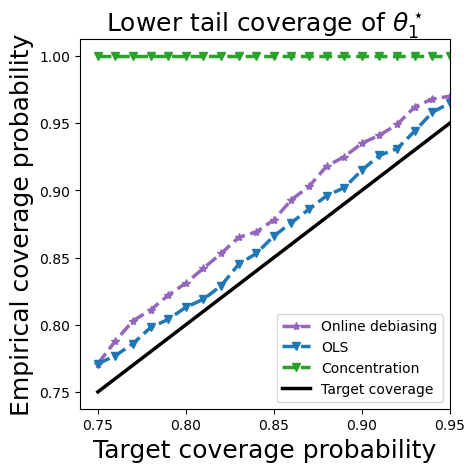

In [9]:
coordinate = 0

from matplotlib.ticker import FormatStrFormatter



plt.plot(1 - alphas, LeftCoverage[:, coordinate], color=colors['OD'], label='Online debiasing', marker=markers['OD'], linestyle = '--', linewidth = 2.5)   
plt.plot(1 - alphas, LeftCoverageols[:, coordinate], color=colors['OLS_gsn'], label='OLS', marker=markers['OLS_gsn'], linestyle = '--', linewidth = 2.5)   
plt.plot(1 - alphas, LeftCoverageconc[:, coordinate], color=colors['OLS_conc'], label='Concentration', marker=markers['OLS_gsn'], linestyle = '--', linewidth = 2.5)   

plt.plot(1- alphas, 1- alphas, color=colors['Nominal'], label='Target coverage', linewidth = 2.5)
plt.legend()
plt.xlim([0.74, 0.95])

plt.title('Lower tail coverage of $\\theta_1^\\star$', fontsize = 18)
plt.xlabel('Target coverage probability', fontsize = 18)
plt.ylabel('Empirical coverage probability' , fontsize = 18)

ax = plt.gca()
ax.set_aspect('auto', adjustable='box')
ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax.set_box_aspect(1)

plt.savefig("Plots/Fig_LinBandit_lower_arm_1_lamPointOne.pdf", format="pdf", bbox_inches="tight")




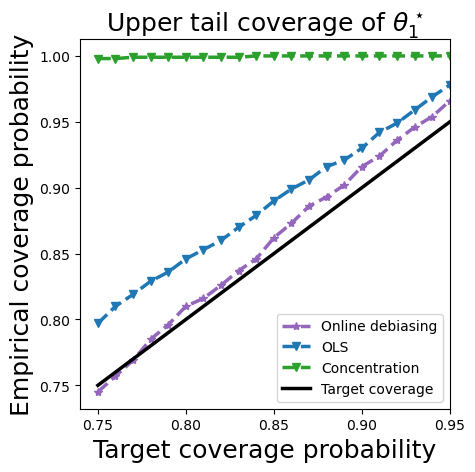

In [10]:
coordinate = 0

from matplotlib.ticker import FormatStrFormatter



plt.plot(1 - alphas, RightCoverage[:, coordinate], color=colors['OD'], label='Online debiasing', marker=markers['OD'], linestyle = '--', linewidth = 2.5)   
plt.plot(1 - alphas, RightCoverageols[:, coordinate], color=colors['OLS_gsn'], label='OLS', marker=markers['OLS_gsn'], linestyle = '--', linewidth = 2.5)   
plt.plot(1 - alphas, RightCoverageconc[:, coordinate], color=colors['OLS_conc'], label='Concentration', marker=markers['OLS_gsn'], linestyle = '--', linewidth = 2.5)   

plt.plot(1- alphas, 1- alphas, color=colors['Nominal'], label='Target coverage', linewidth = 2.5)
plt.legend()
plt.xlim([0.74, 0.95])

plt.title('Upper tail coverage of $\\theta_1^\\star$', fontsize = 18)
plt.xlabel('Target coverage probability', fontsize = 18)
plt.ylabel('Empirical coverage probability' , fontsize = 18)

ax = plt.gca()
ax.set_aspect('auto', adjustable='box')
ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax.set_box_aspect(1)

plt.savefig("Plots/Fig_LinBandit_Upper_arm_1_lamPointOne.pdf", format="pdf", bbox_inches="tight")




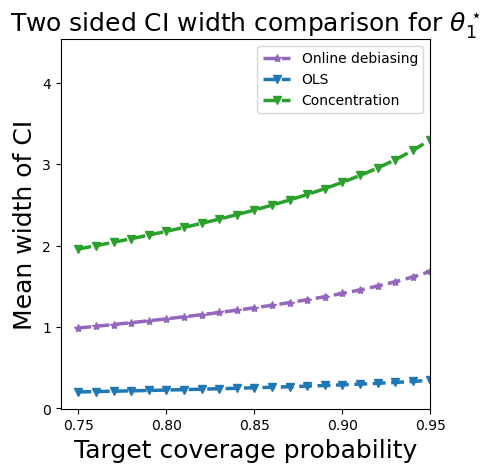

In [11]:
coordinate = 0

from matplotlib.ticker import FormatStrFormatter



plt.plot(1 - alphas, CIwidthOD[:, coordinate], color=colors['OD'], label='Online debiasing', marker=markers['OD'], linestyle = '--', linewidth = 2.5)   
plt.plot(1 - alphas, CIwidthOLS[:, coordinate], color=colors['OLS_gsn'], label='OLS', marker=markers['OLS_gsn'], linestyle = '--', linewidth = 2.5)   
plt.plot(1 - alphas, CIwidthConc[:, coordinate], color=colors['OLS_conc'], label='Concentration', marker=markers['OLS_gsn'], linestyle = '--', linewidth = 2.5)   
plt.legend()
plt.xlim([0.74, 0.95])

plt.title('Two sided CI width comparison for $\\theta_1^\\star$', fontsize = 18)
plt.xlabel('Target coverage probability', fontsize = 18)
plt.ylabel('Mean width of CI' , fontsize = 18)

ax = plt.gca()
ax.set_aspect('auto', adjustable='box')
ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax.set_box_aspect(1)

plt.savefig("Plots/Fig_LinBandit_CI_width_arm_1_lamPointOne.pdf", format="pdf", bbox_inches="tight")




# plots for arm 2

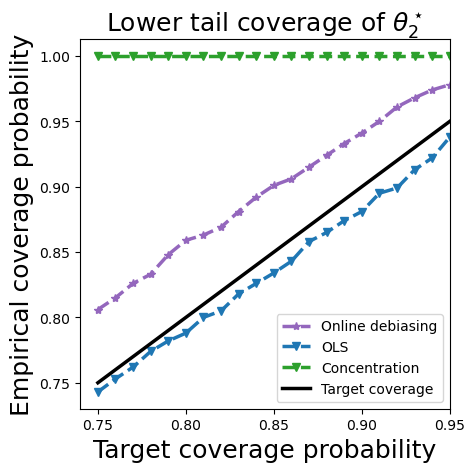

In [12]:
coordinate = 1

from matplotlib.ticker import FormatStrFormatter



plt.plot(1 - alphas, LeftCoverage[:, coordinate], color=colors['OD'], label='Online debiasing', marker=markers['OD'], linestyle = '--', linewidth = 2.5)   
plt.plot(1 - alphas, LeftCoverageols[:, coordinate], color=colors['OLS_gsn'], label='OLS', marker=markers['OLS_gsn'], linestyle = '--', linewidth = 2.5)   
plt.plot(1 - alphas, LeftCoverageconc[:, coordinate], color=colors['OLS_conc'], label='Concentration', marker=markers['OLS_gsn'], linestyle = '--', linewidth = 2.5)   

plt.plot(1- alphas, 1- alphas, color=colors['Nominal'], label='Target coverage', linewidth = 2.5)
plt.legend()
plt.xlim([0.74, 0.95])

plt.title('Lower tail coverage of $\\theta_2^\\star$', fontsize = 18)
plt.xlabel('Target coverage probability', fontsize = 18)
plt.ylabel('Empirical coverage probability' , fontsize = 18)

ax = plt.gca()
ax.set_aspect('auto', adjustable='box')
ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax.set_box_aspect(1)

plt.savefig("Plots/Fig_LinBandit_lower_arm_2_lamPointOne.pdf", format="pdf", bbox_inches="tight")




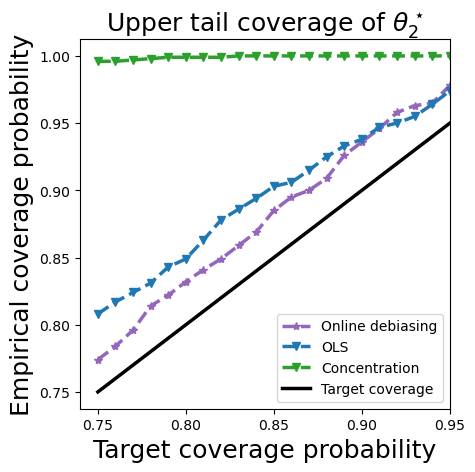

In [13]:
coordinate = 1

from matplotlib.ticker import FormatStrFormatter



plt.plot(1 - alphas, RightCoverage[:, coordinate], color=colors['OD'], label='Online debiasing', marker=markers['OD'], linestyle = '--', linewidth = 2.5)   
plt.plot(1 - alphas, RightCoverageols[:, coordinate], color=colors['OLS_gsn'], label='OLS', marker=markers['OLS_gsn'], linestyle = '--', linewidth = 2.5)   
plt.plot(1 - alphas, RightCoverageconc[:, coordinate], color=colors['OLS_conc'], label='Concentration', marker=markers['OLS_gsn'], linestyle = '--', linewidth = 2.5)   

plt.plot(1- alphas, 1- alphas, color=colors['Nominal'], label='Target coverage', linewidth = 2.5)
plt.legend()
plt.xlim([0.74, 0.95])

plt.title('Upper tail coverage of $\\theta_2^\\star$', fontsize = 18)
plt.xlabel('Target coverage probability', fontsize = 18)
plt.ylabel('Empirical coverage probability' , fontsize = 18)

ax = plt.gca()
ax.set_aspect('auto', adjustable='box')
ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax.set_box_aspect(1)

plt.savefig("Plots/Fig_LinBandit_Upper_arm_2_lamPointOne.pdf", format="pdf", bbox_inches="tight")




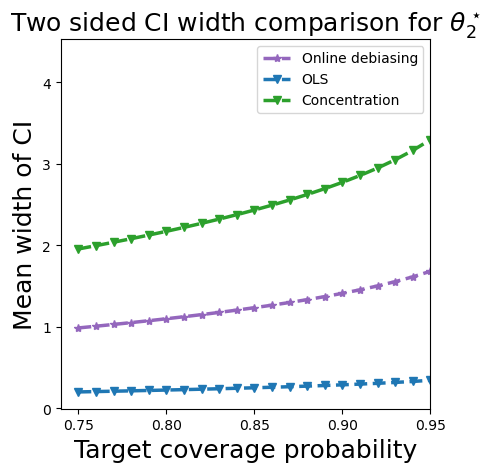

In [14]:
coordinate = 1

from matplotlib.ticker import FormatStrFormatter



plt.plot(1 - alphas, CIwidthOD[:, coordinate], color=colors['OD'], label='Online debiasing', marker=markers['OD'], linestyle = '--', linewidth = 2.5)   
plt.plot(1 - alphas, CIwidthOLS[:, coordinate], color=colors['OLS_gsn'], label='OLS', marker=markers['OLS_gsn'], linestyle = '--', linewidth = 2.5)   
plt.plot(1 - alphas, CIwidthConc[:, coordinate], color=colors['OLS_conc'], label='Concentration', marker=markers['OLS_gsn'], linestyle = '--', linewidth = 2.5)   
plt.legend()
plt.xlim([0.74, 0.95])

plt.title('Two sided CI width comparison for $\\theta_2^\\star$', fontsize = 18)
plt.xlabel('Target coverage probability', fontsize = 18)
plt.ylabel('Mean width of CI' , fontsize = 18)

ax = plt.gca()
ax.set_aspect('auto', adjustable='box')
ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax.set_box_aspect(1)

plt.savefig("Plots/Fig_LinBandit_Ci_width_arm_2_lamPointOne.pdf", format="pdf", bbox_inches="tight")




In [15]:
import dill
dill.dump_session('notebook_LinBandit_lamPointOne_1000_1000.db')